# Arabic/Egyptian Slang Support Sentiment Analysis

This project is aimed to create a sentiment analysis for arabic and egyptian dialect. I choose some assumptions to frame the problem complexity down:
1. Work At the document level, the whole piece of writing is dealt with as one unit and is assigned to a positive, negative or neutral class. This level of analysis supposes that each document expresses an opinion on a single entity and has only one opinion holder. Therefore, it cannot be applied to documents that evaluate or compare multiple entities.

2. Classfication is based on 2 class(positive , negative). excluding any mixed and netural data

3. I choose to work with balanced dataset.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn

import re
import string


# Keras
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifers
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#METRICES
from sklearn import metrics

#plotting style
plt.style.use('seaborn')
%matplotlib notebook

# CUSTOM COLORS
BLUE = '#374eb4'
RED ='#b43323'
GREEN = '#42b471'

## Helper Methods

In [2]:
# ARABIC CLEANING WORDS
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                             """, re.VERBOSE)
def clean_arabic_text(text):
    def normalize_arabic(text):
        text = re.sub("[إأآا]", "ا", text)
        text = re.sub("ى", "ي", text)
        text = re.sub("ؤ", "ء", text)
        text = re.sub("ئ", "ء", text)
        text = re.sub("ة", "ه", text)
        text = re.sub("گ", "ك", text)
        return text

    def remove_diacritics(text):
        text = re.sub(arabic_diacritics, '', text)
        return text

    def remove_punctuations(text):
        translator = str.maketrans('', '', punctuations_list)
        return text.translate(translator)


    def get_arabic_and_full_stop(text):
        text = re.findall(r'[\u0621-\u064a]+|\.', text)
        return text

    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_punctuations(text)
    text = get_arabic_and_full_stop(text)
    text = ' '.join(text).strip()
    return text

#plotting
def my_pie_plot(values, labels, title, colors):
    fig, ax = plt.subplots()
    ax.pie(values, labels=labels,colors=colors,autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title)
    plt.show()

# evaulating peformace of classifer
def evaluate_peformance(y_text, y_pred, y_pred_proba):
    classes = np.unique(y_test)
    if len(classes) >=3:
        y_pred_proba_temp  = y_pred_proba
    else:
        y_pred_proba_temp = y_pred_proba[:, 1]
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred_proba_temp, multi_class="ovr")
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    recall =  metrics.recall_score(y_test, y_pred, average='weighted')
    print("Accuracy:",  round(accuracy,2))
    print("Auc(AREA UNDER CURVE):", round(auc,2))
    print("Precision: ", round(precision,2))
    print("Recall: ", round(recall,2))
    print("Detail:")
    print(metrics.classification_report(y_test, y_pred))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sn.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    fig, ax = plt.subplots()

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  y_pred_proba[:,i])
        ax.plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
        ax.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
        ax.set(xlim=[-0.05,1.0],ylim=[0.0,1.05], xlabel='False Positive Rate',
               ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic(ROC)")
        ax.legend(loc="lower right")
        ax.grid(True)

    plt.show()

## Reading Data

### Parameters

In [3]:
dataset_dir = 'Data\\dataset\\'

#### Kaggle arabic reviews 100k <https://www.kaggle.com/abedkhooli/arabic-100k-reviews>
Modern Standard Arabic as well as dialectal Arabic.

In [4]:
# ARABIC MSA And dialectal Arabic
kaggle_arabic_reviews = dataset_dir + 'Kaggle_arabic_reviews_100k\\ar_reviews_100k.tsv'
kaggle_arabic_reviews_df = pd.read_csv(kaggle_arabic_reviews,delimiter='\t')
kaggle_arabic_reviews_df

,label,text
0,positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...,...
99994,negative,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995,negative,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996,negative,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997,negative,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


In [5]:
# CLEAN FROM MIXED 
kaggle_arabic_reviews_df = kaggle_arabic_reviews_df[kaggle_arabic_reviews_df['label'] != 'mixed'].reset_index(drop=True)
kaggle_arabic_reviews_df

,label,text
0,positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...,...
66661,negative,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
66662,negative,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
66663,negative,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
66664,negative,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


<IPython.core.display.Javascript object>


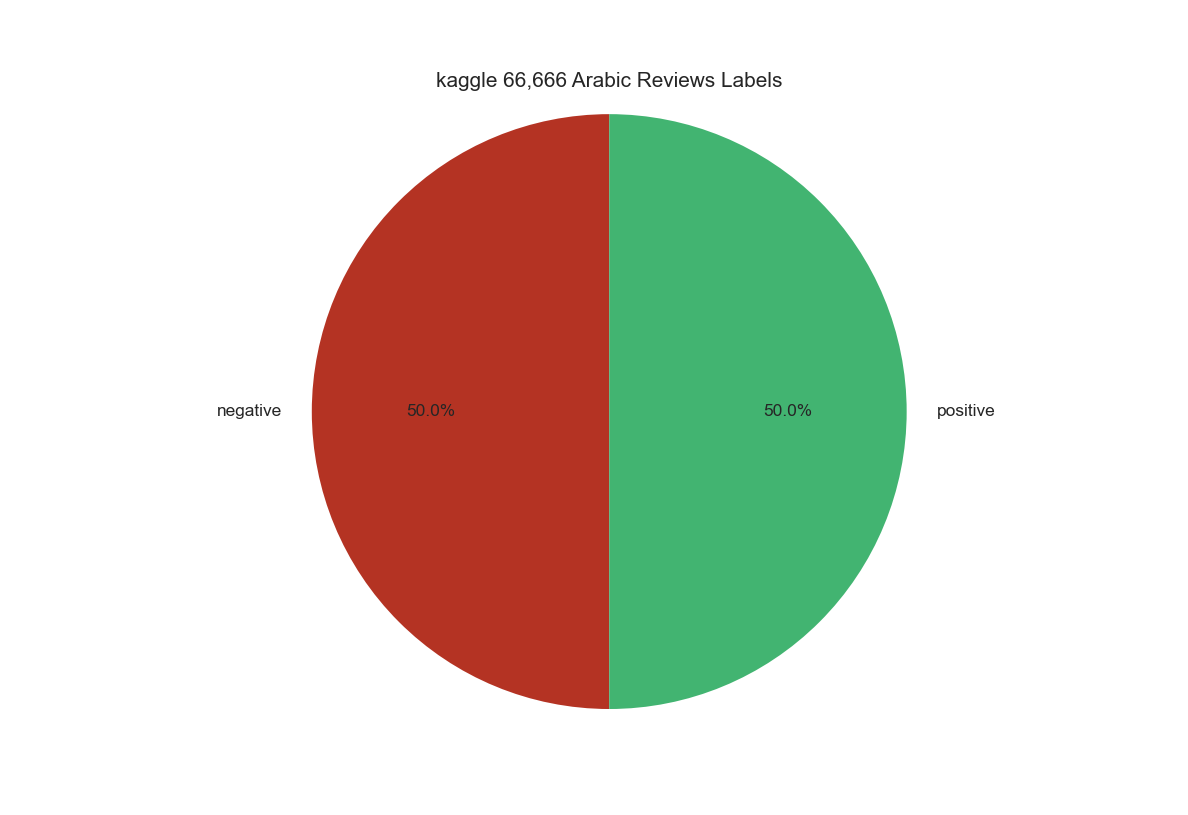

In [6]:
# getting the count dataframe
count_df = kaggle_arabic_reviews_df.groupby(['label']).count().reset_index().rename({'text':'count'},axis=1)
# plotting
my_pie_plot(values=count_df['count'].to_list(),
            labels=count_df['label'].to_list(),
            title=f"kaggle {count_df['count'].sum():,} Arabic Reviews Labels",
            colors=[RED,GREEN]
           )


#### Harvard Egyptian tweets 40k <https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LBXV9O>
Egyptian dialectal Arabic.


In [7]:
# Egyptian dialectal.
harvard_egyptian_tweets = dataset_dir + 'Harvard_Egyptian_tweets_40k\\40000-Egyptian-tweets.tsv'
harvard_egyptian_tweets_df = pd.read_csv(harvard_egyptian_tweets, delimiter='\t')
harvard_egyptian_tweets_df.head()

,text,label
0,اكبر خطا ترتكبه ان تعامل الناس باخلاقك انت مش ...,negative
1,دائما اكره اخر ليله في كل مكان .,negative
2,يارب اللى يسرق تويتاتى يدخل النار .,negative
3,الاسراف فى تناول القهوة يسبب الوفاه .,negative
4,انا اتبهدلت من التراب النهارده. حاجة تقرف .,positive


<IPython.core.display.Javascript object>


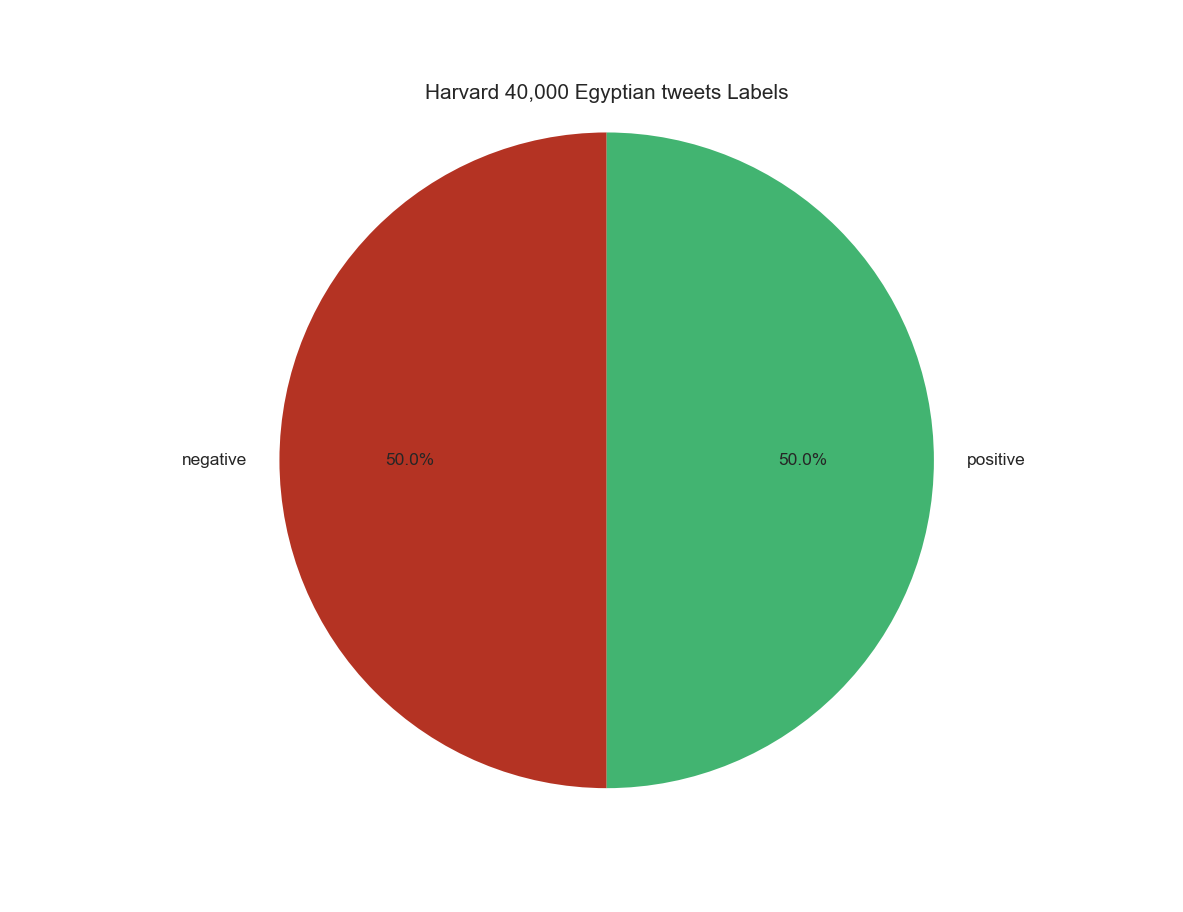

In [8]:
# getting the count dataframe
count_df = harvard_egyptian_tweets_df.groupby(['label']).count().reset_index().rename({'text':'count'},axis=1)
# plotting
my_pie_plot(values=count_df['count'].to_list(),
            labels=count_df['label'].to_list(),
            title=f"Harvard {count_df['count'].sum():,} Egyptian tweets Labels",
            colors=[RED, GREEN])

#### HARD(HOTEL) ARABIC DATASET <https://github.com/elnagara/HARD-Arabic-Dataset>
Modern Standard Arabic as well as dialectal Arabic.

In [9]:
hard_reviews = dataset_dir + 'HARD-Arabic-Dataset-master\\balanced-reviews.txt'
hard_reviews_df = pd.read_csv(hard_reviews, delimiter='\t')
hard_reviews_df

,no,Hotel name,rating,user type,room type,nights,review
0,2,فندق 72,2,مسافر منفرد,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“ممتاز”. النظافة والطاقم متعاون.
1,3,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
2,16,فندق 72,5,زوج,-,أقمت ليلتين,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...
3,20,فندق 72,1,زوج,غرفة قياسية مزدوجة,أقمت ليلة واحدة,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...
4,23,فندق 72,4,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلتين,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...
...,...,...,...,...,...,...,...
105693,412050,زوار انترناشيونال,1,أسرة,غرفة قياسية توأم,أقمت ليلة واحدة,“فند”. لا شئ عجبني. طقم العمل سيئ جدالا يوجد ب...
105694,412051,زوار انترناشيونال,2,زوج,غرفة ديلوكس توأم,أقمت ليلتين,“سيئ”. قربه من المسجد النبوي الشريف. استخدام م...
105695,412054,زوار انترناشيونال,2,زوج,غرفة قياسية ثلاثية,أقمت ليلة واحدة,“اسوأ إقامة في الرحلة !”. القرب من الحرم. كل ش...
105696,412058,زوار انترناشيونال,2,أسرة,غرفة قياسية رباعية,أقمت 3 ليالي,“دون المستوى”. قربه من الحرم. كل شيء


In [10]:
# cleaning on data
# Extract important cols
hard_reviews_df = hard_reviews_df[['rating','review']]
# rating 4,5 postivit, exclude 3 , rating 1,2 negative
hard_reviews_df = hard_reviews_df[hard_reviews_df['rating']!=3]
hard_reviews_df['label'] = np.where(hard_reviews_df['rating']>3,'positive','negative')
hard_reviews_df = hard_reviews_df[['review','label']].reset_index(drop=True).rename(columns={'review':'text'})
hard_reviews_df

,text,label
0,“ممتاز”. النظافة والطاقم متعاون.,negative
1,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...,positive
2,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...,positive
3,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...,negative
4,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...,positive
...,...,...
105693,“فند”. لا شئ عجبني. طقم العمل سيئ جدالا يوجد ب...,negative
105694,“سيئ”. قربه من المسجد النبوي الشريف. استخدام م...,negative
105695,“اسوأ إقامة في الرحلة !”. القرب من الحرم. كل ش...,negative
105696,“دون المستوى”. قربه من الحرم. كل شيء,negative


<IPython.core.display.Javascript object>


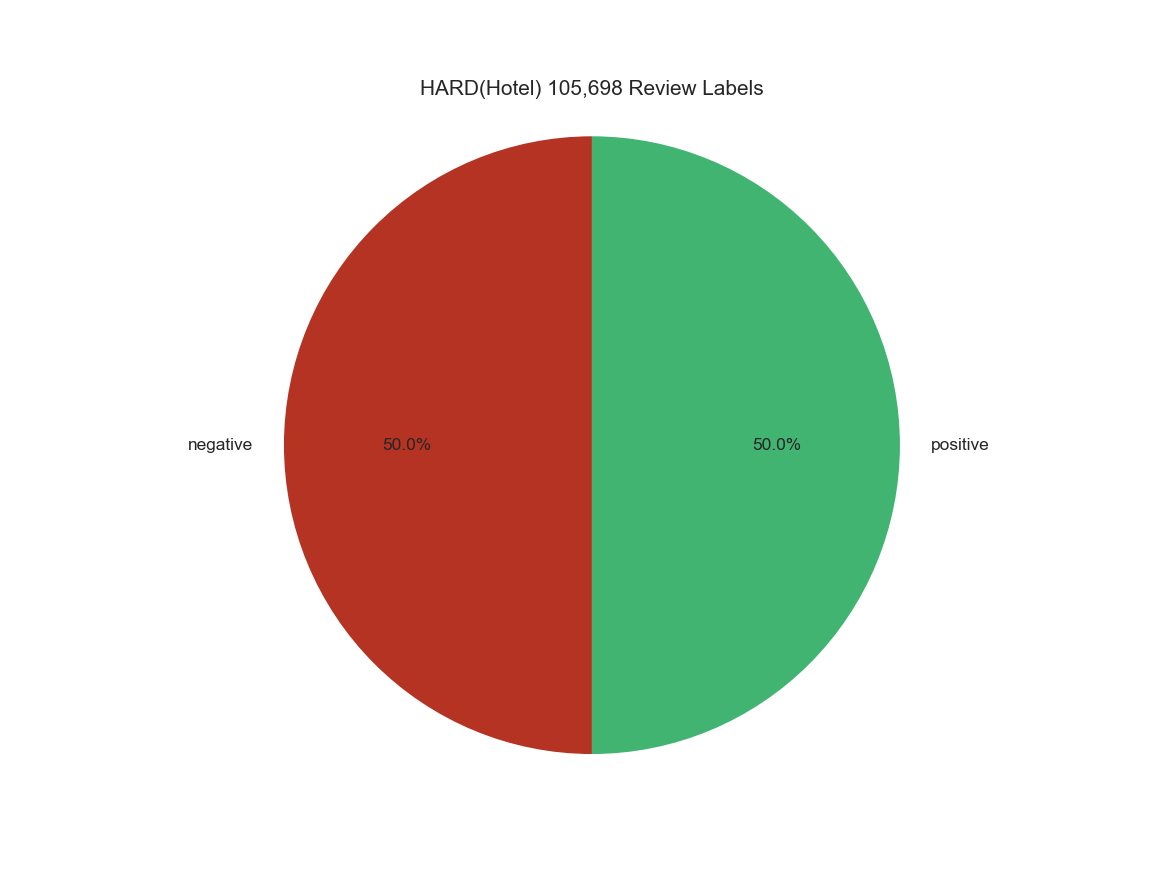

In [11]:
# getting the count dataframe
count_df = hard_reviews_df.groupby(['label']).count().reset_index().rename({'text':'count'},axis=1)
# plotting
my_pie_plot(values=count_df['count'].to_list(),
            labels=count_df['label'].to_list(),
            title=f"HARD(Hotel) {count_df['count'].sum():,} Review Labels",
            colors=[RED, GREEN])

#### BARD(BOOKS) ARABIC DATASET <https://github.com/elnagara/BRAD-Arabic-Dataset>
Modern Standard Arabic as well as dialectal Arabic.

In [12]:
bard_reviews = dataset_dir + 'BRAD-Arabic-Dataset-master\\bal-clean-reviews.tsv.txt'
bard_reviews_df = pd.read_csv(bard_reviews, delimiter='\t')
bard_reviews_df

,rating,review id,user id,book id,review
0,2,1665743403,21435637,13637412,قرأتها من فترة طويلة و لا يحضرني فيها الا اعجا...
1,2,1664872313,20015365,13637412,كان نفسي احب الرواية دي، أغلب اصدقائي اللي قرأ...
2,2,1659286461,56517018,13637412,عملوا منها مسلسل. اجوف المسلسل ولا اقرى الرواي...
3,2,1657686339,22103652,13637412,لطيفه :). كأنك بتتفرج ع مسلسل بس نوعا ما لطيف
4,2,1657401919,56445490,13637412,الرواية جميلة تحمل معاني ورسالات كثيرة اراد ال...
...,...,...,...,...,...
156501,4,1669006546,13011445,11159979,من الكتب الرائده والأولى في مجال العلاقات الإن...
156502,4,1598566934,4906067,698911,كتاب التاو تي تشينغ _ إنجيل الحكمة التاوية في ...
156503,5,1676964118,21361576,9686838,عجبنى التفاصيل، تفاصيل كتير جدا ودى اكتر حاجة ...
156504,5,1679128750,40708424,86940,رغم مشاهدة سلسلة الأفلام، إلا أنه للرواية طعم ...


In [13]:
# cleaning on data
# Extract important cols
bard_reviews_df = bard_reviews_df[['rating','review']]
# rating 4,5 postivit, exclude 3 , rating 1,2 negative
bard_reviews_df = bard_reviews_df[bard_reviews_df['rating']!=3]
bard_reviews_df['label'] = np.where(bard_reviews_df['rating']>3,'positive','negative')
bard_reviews_df = bard_reviews_df[['review','label']].reset_index(drop=True).rename(columns={'review':'text'})
bard_reviews_df

,text,label
0,قرأتها من فترة طويلة و لا يحضرني فيها الا اعجا...,negative
1,كان نفسي احب الرواية دي، أغلب اصدقائي اللي قرأ...,negative
2,عملوا منها مسلسل. اجوف المسلسل ولا اقرى الرواي...,negative
3,لطيفه :). كأنك بتتفرج ع مسلسل بس نوعا ما لطيف,negative
4,الرواية جميلة تحمل معاني ورسالات كثيرة اراد ال...,negative
...,...,...
156501,من الكتب الرائده والأولى في مجال العلاقات الإن...,positive
156502,كتاب التاو تي تشينغ _ إنجيل الحكمة التاوية في ...,positive
156503,عجبنى التفاصيل، تفاصيل كتير جدا ودى اكتر حاجة ...,positive
156504,رغم مشاهدة سلسلة الأفلام، إلا أنه للرواية طعم ...,positive


<IPython.core.display.Javascript object>


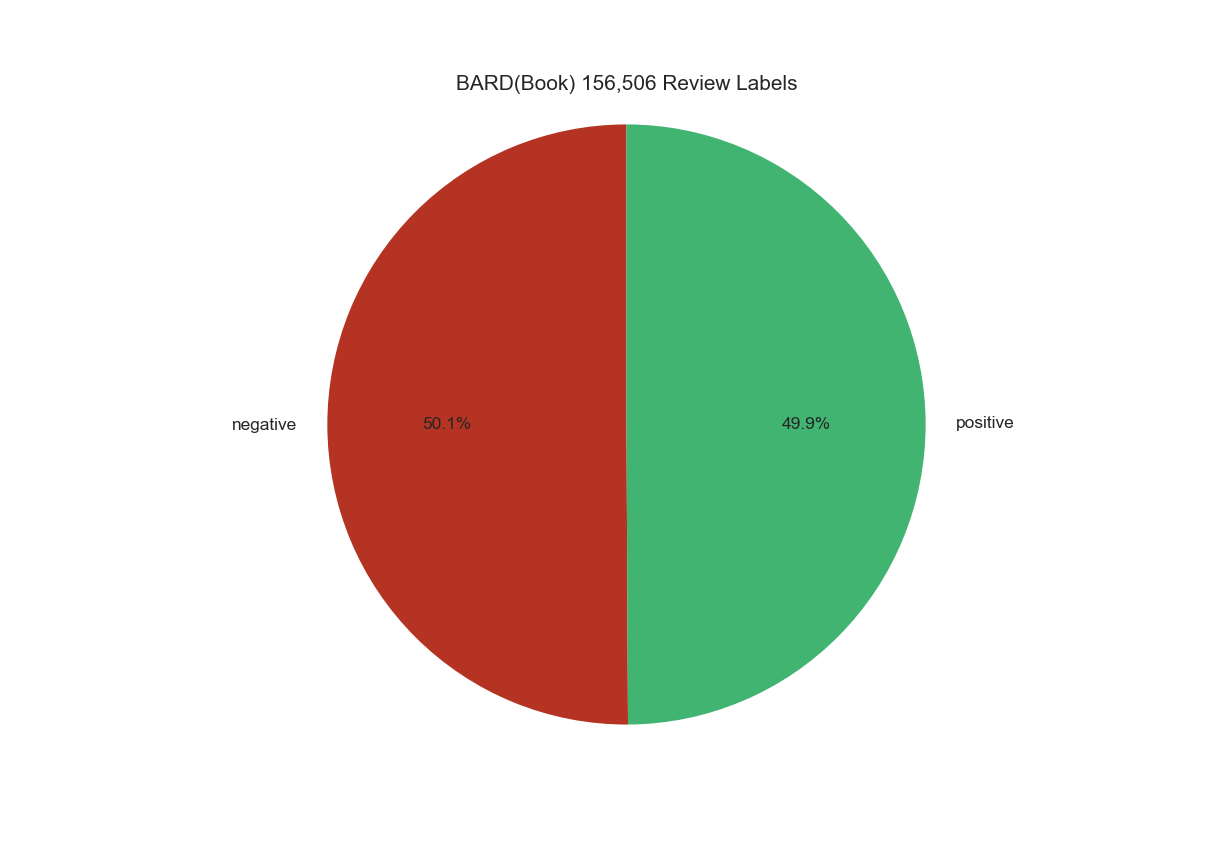

In [14]:
# getting the count dataframe
count_df = bard_reviews_df.groupby(['label']).count().reset_index().rename({'text':'count'},axis=1)
# plotting
my_pie_plot(values=count_df['count'].to_list(),
            labels=count_df['label'].to_list(),
            title=f"BARD(Book) {count_df['count'].sum():,} Review Labels",
            colors=[RED, GREEN])

#### Merging all Dataset

In [15]:
all_dfs = [kaggle_arabic_reviews_df,
           harvard_egyptian_tweets_df,
           hard_reviews_df,
           bard_reviews_df
          ]
all_reviews_df = pd.concat(all_dfs, ignore_index=True)
all_reviews_df

,label,text
0,positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...,...
368865,positive,من الكتب الرائده والأولى في مجال العلاقات الإن...
368866,positive,كتاب التاو تي تشينغ _ إنجيل الحكمة التاوية في ...
368867,positive,عجبنى التفاصيل، تفاصيل كتير جدا ودى اكتر حاجة ...
368868,positive,رغم مشاهدة سلسلة الأفلام، إلا أنه للرواية طعم ...


<IPython.core.display.Javascript object>


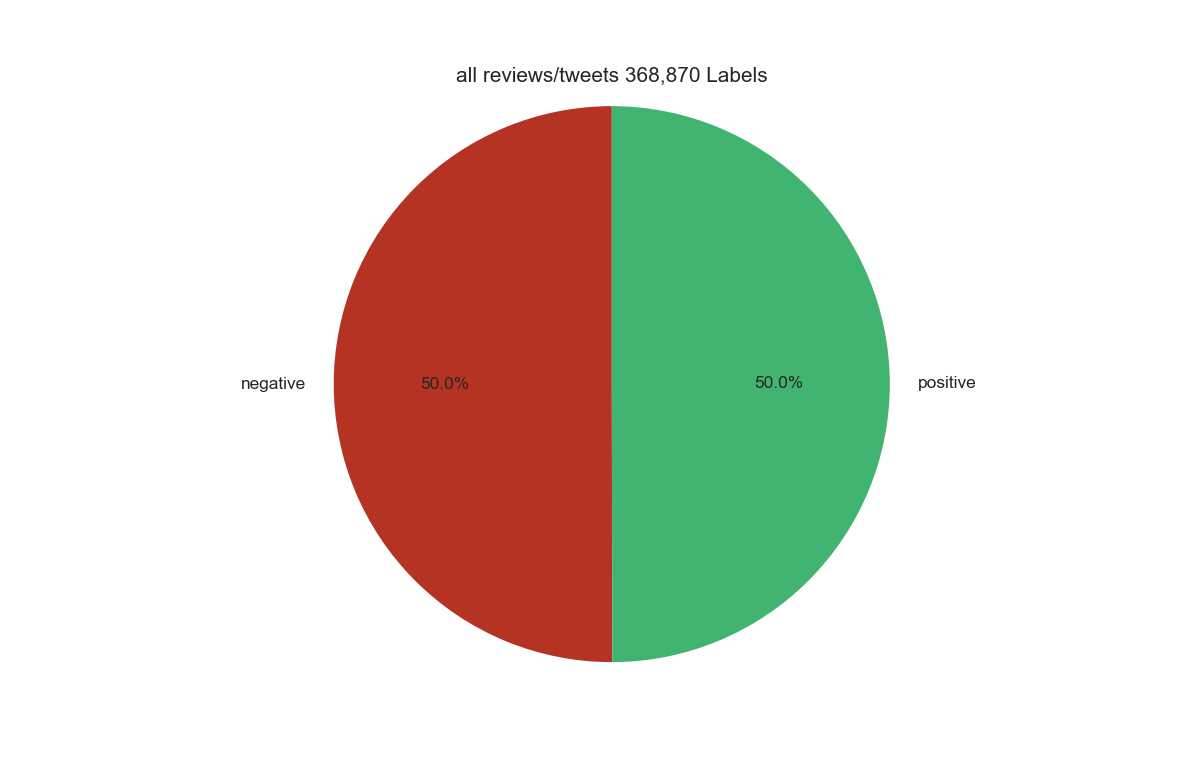

In [16]:
# getting the count dataframe
count_df = all_reviews_df.groupby(['label']).count().reset_index().rename({'text':'count'},axis=1)
# plotting
my_pie_plot(values=count_df['count'].to_list(),
            labels=count_df['label'].to_list(),
            title=f"all reviews/tweets {count_df['count'].sum():,} Labels",
            colors=[RED, GREEN])

## Preparing data

#### Prepare stop words list

In [17]:
stop_words_file = 'Data\\stop_word.txt'
stop_words_list = pd.read_csv(stop_words_file)['stop words'].unique()
#clean stop words
print('number of stop words :',len(stop_words_list))
print('some of the stop words' ,stop_words_list[:100])

number of stop words : 750
some of the stop words ['،' 'ء' 'ءَ' 'آ' 'آب' 'آذار' 'آض' 'آل' 'آمينَ' 'آناء' 'آنفا' 'آه' 'آهاً'
 'آهٍ' 'آهِ' 'أ' 'أبدا' 'أبريل' 'أبو' 'أبٌ' 'أجل' 'أجمع' 'أحد' 'أخبر'
 'أخذ' 'أخو' 'أخٌ' 'أربع' 'أربعاء' 'أربعة' 'أربعمئة' 'أربعمائة' 'أرى'
 'أسكن' 'أصبح' 'أصلا' 'أضحى' 'أطعم' 'أعطى' 'أعلم' 'أغسطس' 'أفريل'
 'أفعل به' 'أفٍّ' 'أقبل' 'أكتوبر' 'أل' 'ألا' 'ألف' 'ألفى' 'أم' 'أما'
 'أمام' 'أمامك' 'أمامكَ' 'أمد' 'أمس' 'أمسى' 'أمّا' 'أن' 'أنا' 'أنبأ' 'أنت'
 'أنتم' 'أنتما' 'أنتن' 'أنتِ' 'أنشأ' 'أنه' 'أنًّ' 'أنّى' 'أهلا' 'أو' 'أوت'
 'أوشك' 'أول' 'أولئك' 'أولاء' 'أولالك' 'أوّهْ' 'أى' 'أي' 'أيا' 'أيار'
 'أيضا' 'أيلول' 'أين' 'أيّ' 'أيّان' 'أُفٍّ' 'ؤ' 'إحدى' 'إذ' 'إذا' 'إذاً'
 'إذما' 'إذن' 'إزاء' 'إلى' 'إلي']


In [18]:
#CLEAN LIST OF STOP WORDS
stop_words_list_cleaned = set([clean_arabic_text(x.strip()) for x in stop_words_list])
# remove empty 
stop_words_list_cleaned = [x for x in stop_words_list_cleaned if x!='']
print('after cleaning stop words list count ',len(stop_words_list_cleaned), ' some of words ',stop_words_list_cleaned[:100])

after cleaning stop words list count  669  some of words  ['عسي', 'تينك', 'لا', 'اياهم', 'الاخيره', 'ذانك', 'اياها', 'ثلاثون', 'خميس', 'عدد', 'مما', 'يمين', 'ماي', 'هيا', 'جير', 'لان', 'ثلاث', 'خ', 'خمسه', 'نا', 'ال', 'كانت', 'راء', 'ذان', 'اربعه', 'نفسه', 'هو', 'هي', 'سين', 'سته', 'الماضي', 'اول', 'انشا', 'هاته', 'وجد', 'تحت', 'بات', 'بغته', 'نون', 'حول', 'علق', 'عاد', 'رابع', 'فوق', 'اليك', 'اعاده', 'سبعين', 'مءتان', 'خلافا', 'سقي', 'اللتين', 'اضحي', 'االا', 'افعل به', 'نوفمبر', 'اربعاء', 'جانفي', 'اوت', 'عليه', 'معه', 'خاء', 'واوضح', 'زاي', 'تبدل', 'السابق', 'تموز', 'لهم', 'يكون', 'عام', 'اكتوبر', 'كلتا', 'تلقاء', 'جيم', 'خلا', 'تاره', 'ذات', 'ذه', 'لقاء', 'وثي', 'ن', 'وليس', 'يوليو', 'لا سيما', 'واضاف', 'سوي', 'اذن', 'ميم', 'ولايزال', 'ثلاثين', 'بس', 'حمدا', 'بسبب', 'قام', 'لن', 'اري', 'اعلم', 'تخذ', 'حادي', 'منه', 'لايزال']


#### Clean dataset 

In [19]:
# CLEAN TEXT FIRST
# REMOVE STOP WORDS? STOP WORDS COLLECTED
# TRY STEMMING? https://github.com/linuxscout/tashaphyne/
# TRY LEMMIZATION IF YOU FOUND?

In [20]:
# clean text
all_reviews_df['clean_text'] = all_reviews_df['text'].apply(lambda x: clean_arabic_text(x))
# using stop words
all_reviews_df['clean_text_with_stop'] = all_reviews_df['clean_text'].apply(lambda x: ' '.join([z for z in x.split() if z not in stop_words_list_cleaned]))
all_reviews_df

,label,text,clean_text,clean_text_with_stop
0,positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...,ممتاز نوعا ما النظافه والموقع والتجهيز والشاطي...,ممتاز نوعا النظافه والموقع والتجهيز والشاطيء ا...
1,positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...,احد اسباب نجاح الامارات ان كل شخص في هذه الدول...,اسباب نجاح الامارات شخص الدوله يعشق ترابها نحب...
2,positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...,هادفه وقويه تنقلك من صخب شوارع القاهره الي هدو...,هادفه وقويه تنقلك صخب شوارع القاهره هدوء جبال ...
3,positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...,خلصنا مبدءيا اللي مستني ابهار زي الفيل الازرق ...,خلصنا مبدءيا اللي مستني ابهار زي الفيل الازرق ...
4,positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...,ياسات جلوريا جزء لا يتجزا من دبي فندق متكامل ا...,ياسات جلوريا جزء يتجزا دبي فندق متكامل الخدمات...
...,...,...,...,...
368865,positive,من الكتب الرائده والأولى في مجال العلاقات الإن...,من الكتب الراءده والاولي في مجال العلاقات الان...,الكتب الراءده والاولي مجال العلاقات الانسانيه ...
368866,positive,كتاب التاو تي تشينغ _ إنجيل الحكمة التاوية في ...,كتاب التاو تي تشينغ انجيل الحكمه التاويه في ال...,كتاب التاو تشينغ انجيل الحكمه التاويه الصين ال...
368867,positive,عجبنى التفاصيل، تفاصيل كتير جدا ودى اكتر حاجة ...,عجبني التفاصيل تفاصيل كتير جدا ودي اكتر حاجه خ...,عجبني التفاصيل تفاصيل كتير ودي اكتر حاجه خلتني...
368868,positive,رغم مشاهدة سلسلة الأفلام، إلا أنه للرواية طعم ...,رغم مشاهده سلسله الافلام الا انه للروايه طعم ت...,رغم مشاهده سلسله الافلام للروايه طعم تاني العل...


In [21]:
# CLEAN with LEXICON DATA? 


#### Splitting data

In [22]:
#SPLITTING DATA
test_size = 0.2
X = all_reviews_df['clean_text_with_stop']
y = all_reviews_df['label']
spliter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
splitted = spliter.split(X,y)
for train_index, test_index in splitted:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Following approaches I will try:
1. N-GRAM, P-GRAM,.. with TF-IDF use different classifers ( SVM , naive bayes, k-means... )
2. maybe use features reduction? chi2-square?
3. TF-IDF with lexicon features(count of positive, count of negative, maybe just 1,0,1,0 if it word exist) ( SVM , naive bayes, k-means...)
4. Word embedding with aravec (get the features) then to a neural network
5. Word embedding with arabic-BERT (get the features) then to a neural network
6. hybrid approach of all above features?

## Building the model

###  Feature Extraction Using TF-IDF Techniuqe

In [23]:
#Parameters
ngram = 2
features = 20000

In [24]:
# Extracting features
my_tfidf_vectorizer= TfidfVectorizer(min_df=0.0001,
                                     max_df=0.95,
                                     analyzer='word',
                                     max_features=features,
                                     ngram_range=(1, ngram))
X_train_features = my_tfidf_vectorizer.fit_transform(X_train)

In [25]:
# MAY USE LEXICON TO ADD EXTRA FEATURES! (COUNT OF POSTIIVE, COUNT OF NEGATIVE)
# GET STOP WORDS (HIGH FREQUENCY)
# GET NAMED ENTITY (PERHAPS DOESN"T REFELCT ANYTHING)

In [26]:
features_names = my_tfidf_vectorizer.get_feature_names()
print(features_names[:200])

['اءمن', 'ابا', 'اباحي', 'اباحيه', 'ابالغ', 'ابان', 'اباه', 'ابتداء', 'ابتداءي', 'ابتدي', 'ابتديت', 'ابتذال', 'ابتسامه', 'ابتسم', 'ابتسمت', 'ابتعد', 'ابتعدت', 'ابتكار', 'ابحث', 'ابد', 'ابداء', 'ابداع', 'ابداعا', 'ابداعه', 'ابداعي', 'ابداعيه', 'ابدع', 'ابدع الكاتب', 'ابدعت', 'ابدي', 'ابديه', 'ابراج', 'ابراز', 'ابراهيم', 'ابراهيم اصلان', 'ابراهيم الفقي', 'ابراهيم عيسي', 'ابراهيم نصر', 'ابراهيم نصرالله', 'ابرز', 'ابسط', 'ابشع', 'ابطال', 'ابطال الروايه', 'ابطال القصه', 'ابطاله', 'ابطالها', 'ابعاد', 'ابعد', 'ابعد الحدود', 'ابعد حد', 'ابقي', 'ابكاني', 'ابكتني', 'ابكي', 'ابلاغ', 'ابلغ', 'ابليس', 'ابن', 'ابن القيم', 'ابن تيميه', 'ابن حزم', 'ابن خلدون', 'ابن رشد', 'ابن سينا', 'ابن عربي', 'ابناء', 'ابناءه', 'ابناءها', 'ابناءهم', 'ابنته', 'ابنتها', 'ابنتي', 'ابنه', 'ابنها', 'ابني', 'ابهرتني', 'ابهرني', 'ابواب', 'ابوظبي', 'ابوك', 'ابوه', 'ابوها', 'ابويا', 'ابي', 'ابي بكر', 'ابي طالب', 'ابيات', 'ابيض', 'ابيه', 'ابيها', 'ات', 'اتابع', 'اتاثر', 'اتاثرت', 'اتاكد', 'اتامل', 'اتباع', 'اتباعه', 'اتبع', '

In [27]:
# WE CAN USE FEATURES Selcection WITH https://machinelearningmastery.com/chi-squared-test-for-machine-learning/ 
# NOT WORKING WE CAN DO IT MANUALLY THEN LATER

### Training

##### Naive Bayes

In [28]:
nb_classifer = MultinomialNB()
nb_classifer.fit(X_train_features, y_train)

MultinomialNB()

### Testing

In [29]:
# TRAINING
X_test_transformed = my_tfidf_vectorizer.transform(X_test)
y_predicted = nb_classifer.predict(X_test_transformed)
y_predicted_prob = nb_classifer.predict_proba(X_test_transformed)

Accuracy: 0.83
Auc(AREA UNDER CURVE): 0.91
Precision:  0.83
Recall:  0.83
Detail:
              precision    recall  f1-score   support

    negative       0.84      0.82      0.83     36912
    positive       0.83      0.84      0.83     36862

    accuracy                           0.83     73774
   macro avg       0.83      0.83      0.83     73774
weighted avg       0.83      0.83      0.83     73774



<IPython.core.display.Javascript object>


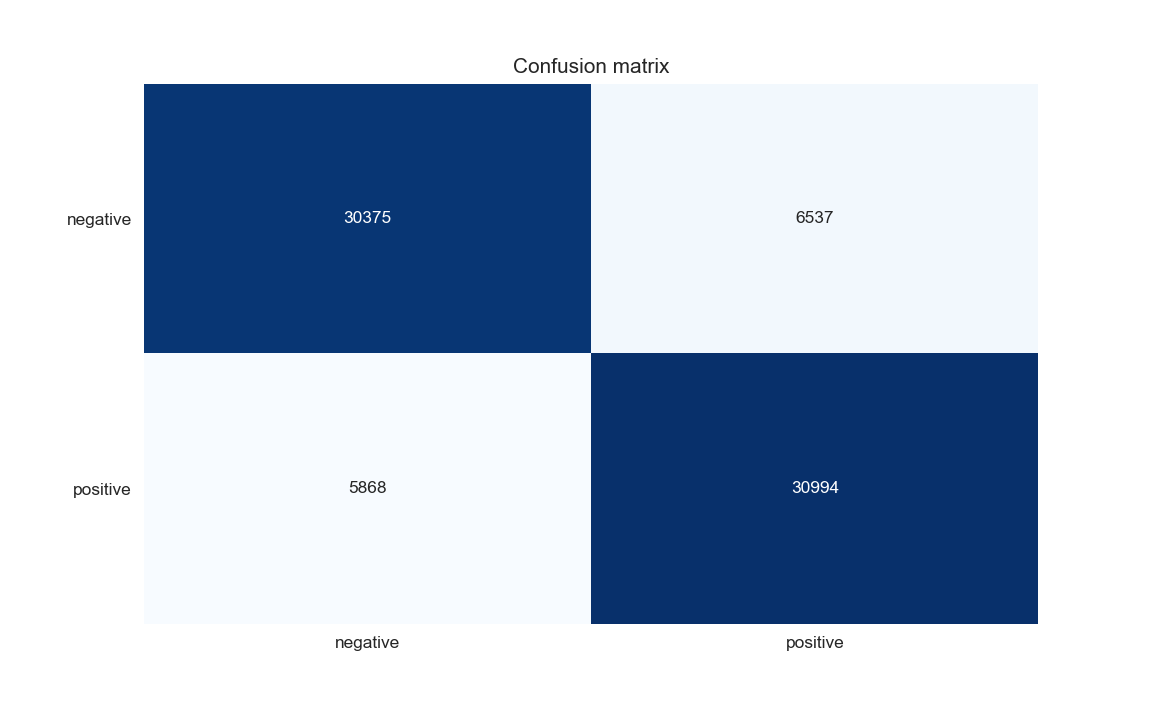

<IPython.core.display.Javascript object>


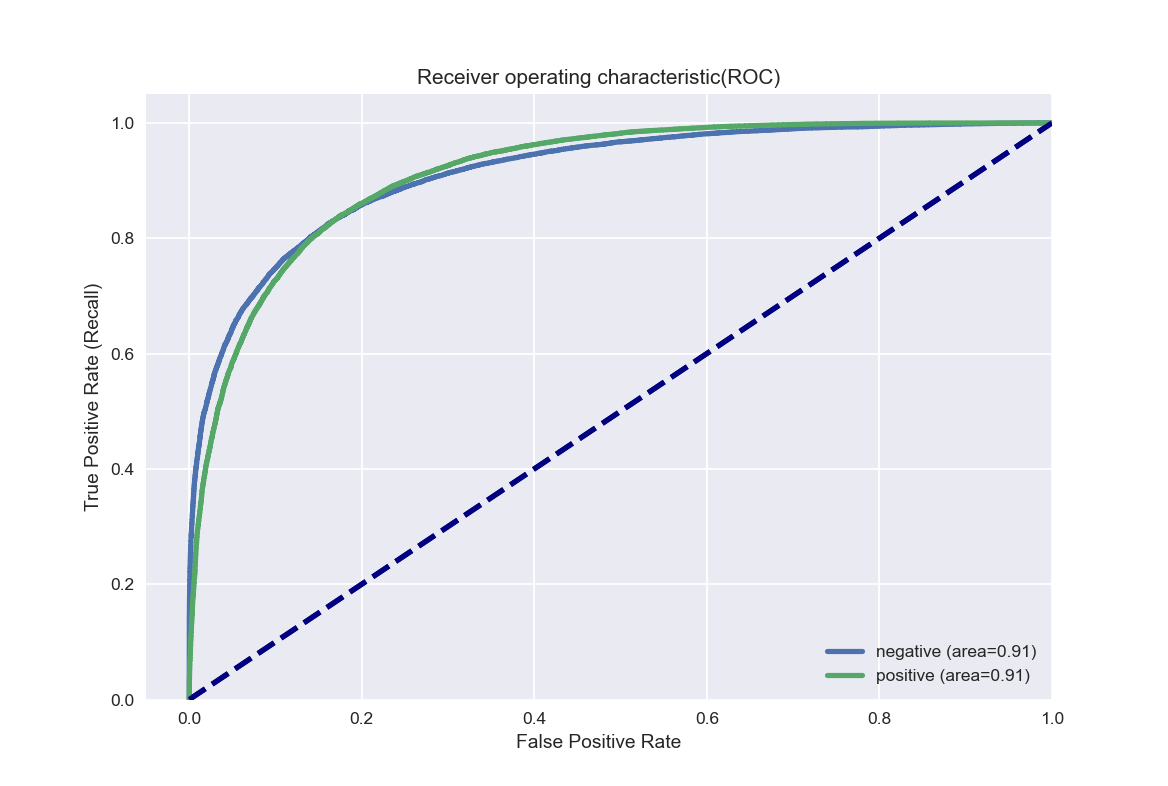

In [30]:
evaluate_peformance(y_test, y_predicted, y_predicted_prob)

In [31]:
#report of different dataset

## Report of different configurations
| Data                               | Cleaning             | Model         | No. of Classes | Features                              | Count  | Training number | Testing size | Precision | Recall | Accuracy | AUC  |
|------------------------------------|----------------------|---------------|----------------|---------------------------------------|--------|-----------------|--------------|-----------|--------|----------|------|
| Kaggle Arabic Reviews-Balanced     | general + stop words | MultinomialNB | 2              | TF-IDF (20000 feature , ngram (1,2) ) | 66666  | 53332           | 13334        | 0.84      | 0.84   | 0.84     | 0.93 |
| HARD Arabic Hotel Reviews-Balanced | general + stop words | MultinomialNB | 2              | TF-IDF (20000 feature , ngram (1,2) ) | 105698 | 84558           | 21140        | 0.91      | 0.91   | 0.91     | 0.97 |
| BARD Arabic Book Reviews-Balanced  | general + stop words | MultinomialNB | 2              | TF-IDF (20000 feature , ngram (1,2) ) | 156506 | 125204          | 31302        | 0.81      | 0.81   | 0.81     | 0.89 |
| Egyptians Harvard Tweets-Balanced  | general + stop words | MultinomialNB | 2              | TF-IDF (20000 feature , ngram (1,2) ) | 40000  | 32000           | 8000         | 0.8       | 0.8    | 0.8      | 0.89 |
| ALL-Balanced                       | general + stop words | MultinomialNB | 2              | TF-IDF (20000 feature , ngram (1,2) ) | 368870 | 295096          | 73774        | 0.83      | 0.83   | 0.83     | 0.91 |

## Test In the wild

In [32]:
def test_phrases(phrases_list, vectroizer, classifer):
    # return phrases with sentiment and features found
    # Clean TEXT
    phrases_cleaned = [clean_arabic_text(text) for text in phrases_list]
    phrases_cleaned_no_stopword = []
    for phrase in phrases_cleaned:
        new_phrase = ' '.join([z for z in phrase.split() if z not in stop_words_list_cleaned])
        phrases_cleaned_no_stopword.append(new_phrase)
    # Vectorize

    phrases_vectorized = vectroizer.transform(phrases_cleaned_no_stopword)
    phrases_predicted = classifer.predict(phrases_vectorized)

    return phrases_cleaned_no_stopword, phrases_predicted

In [33]:
phrases = [
    'جهاز محترم جدا مع ارخص سعر دايما شكرا سوقزكوم',
    'كل حاجة فيه تمام لكن بيهنج ويبط|أ لو الذاكرة الداخلية اتملى أكتر من نصفها حجك الشاشة جيد والألوان جيدة والسرعة معقولة بيبطأ ويهمج لما الاكرة الداخلية يتملي أكتر من نصها',
    'منتج جميل جدا منتج جميل بالنسبه لسعره .. والتوصيل في ميعاده واحترام .. انا في انتظار اوردر تاني هيوصلي .. اتمني مايخبش ظني وتكمل الفرحه',
    'اللحامات باينه والتقفيل مش حلو'
]
cleand_phrases, predictions = test_phrases(phrases, my_tfidf_vectorizer, nb_classifer)
for idx in range(len(cleand_phrases)):
    print(str(idx),')', predictions[idx],'--->',cleand_phrases[idx],'--->',phrases[idx])

0 ) positive ---> جهاز محترم ارخص سعر دايما شكرا سوقزكوم ---> جهاز محترم جدا مع ارخص سعر دايما شكرا سوقزكوم
1 ) negative ---> حاجه تمام بيهنج ويبطا الذاكره الداخليه اتملي اكتر نصفها حجك الشاشه جيد والالوان جيده والسرعه معقوله بيبطا ويهمج الاكره الداخليه يتملي اكتر نصها ---> كل حاجة فيه تمام لكن بيهنج ويبط|أ لو الذاكرة الداخلية اتملى أكتر من نصفها حجك الشاشة جيد والألوان جيدة والسرعة معقولة بيبطأ ويهمج لما الاكرة الداخلية يتملي أكتر من نصها
2 ) positive ---> منتج جميل منتج جميل بالنسبه لسعره والتوصيل ميعاده واحترام انتظار اوردر تاني هيوصلي اتمني مايخبش ظني وتكمل الفرحه ---> منتج جميل جدا منتج جميل بالنسبه لسعره .. والتوصيل في ميعاده واحترام .. انا في انتظار اوردر تاني هيوصلي .. اتمني مايخبش ظني وتكمل الفرحه
3 ) negative ---> اللحامات باينه والتقفيل مش حلو ---> اللحامات باينه والتقفيل مش حلو


### Resources

| Title                                                                                         | Date | Link                                                                                                                                          |
|-----------------------------------------------------------------------------------------------|------|-----------------------------------------------------------------------------------------------------------------------------------------------|
| A comprehensive study for Arabic   Sentiment Analysis (Challenges and Applications)           | 2019 | https://www.sciencedirect.com/science/article/pii/S1110866519300945?via%3Dihub                                                                |
| Sentiment analysis in Arabic: A review of   the literature                                    | 2017 | https://www.sciencedirect.com/science/article/pii/S2090447917300862?via%3Dihub                                                                |
| Arabic 100k Reviews \| Kaggle                                                                 | 2020 | https://www.kaggle.com/abedkhooli/arabic-100k-reviews                                                                                         |
| elnagara/HARD-Arabic-Dataset                                                                  | 2016 | https://github.com/elnagara/HARD-Arabic-Dataset                                                                                               |
| elnagara/BRAD-Arabic-Dataset                                                                  | 2016 | https://github.com/elnagara/BRAD-Arabic-Dataset                                                                                               |
| mahmoudnabil/labr                                                                             | 2015 | https://github.com/mahmoudnabil/labr                                                                                                          |
| Harvard Corpus on Arabic Egyptian tweets                                                      | 2019 | https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LBXV9O                                                               |
| SENTIMENT ANALYSIS – THE LEXICON BASED   APPROACH                                             | 2019 | https://alphabold.com/sentiment-analysis-the-lexicon-based-approach/                                                                          |
| NileULex: A Phrase and Word Level   Sentiment Lexicon for Egyptian and Modern Standard Arabic | 2016 | https://paperswithcode.com/paper/nileulex-a-phrase-and-word-level-sentiment |
| arabic-stop-words                                                                             | 2016 | https://github.com/mohataher/arabic-stop-words                                                                                                |